>- import packeges

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
import joblib 
from pathlib import Path

>- Define functions

In [21]:
# Define functions to calculate NDVI and NDWI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-10)

def calculate_ndwi(nir, green):
    return (nir - green) / (nir + green + 1e-10)

# Function to extract mean NDVI & NDWI as features
def extract_features(image_path):
    with rasterio.open(image_path) as src:
        bands = src.read()
        nir, red, green = bands[4], bands[2], bands[1]  # Adjust based on band order
        
        ndvi = calculate_ndvi(nir, red)
        ndwi = calculate_ndwi(nir, green)

        return [np.mean(ndvi), np.mean(ndwi)]  # Use mean as feature

>- load dataset

In [22]:
# Load dataset efficiently
train_dataset_path = Path('../../../../data/model/Patches/Train/')
test_dataset_path = Path('../../../../data/model/Patches/Test/')
growth_stages = ["germination", "tillering", "grand_growth", "ripening"]
X, X_test, y, y_test = [], [], [], []

for idx, stage in enumerate(growth_stages):
    stage_path = train_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        X.append(extract_features(img_path))
        y.append(idx)

X = np.array(X)
y = np.array(y)

for idx, stage in enumerate(growth_stages):
    stage_path = test_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        X_test.append(extract_features(img_path))
        y_test.append(idx)

X_test = np.array(X_test)
y_test = np.array(y_test)

>-  setup Random Forest model

In [23]:
# Define parameter grid for Random Forest
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initialize Random Forest and GridSearchCV
rf_model = RandomForestClassifier(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(rf_model, param_grid, cv=kf, n_jobs=-1, verbose=2, return_train_score=True)

# Train model with cross-validation
grid_search.fit(X, y)

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Train the model on the entire training dataset
best_model.fit(X, y)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

>- Evaluate model

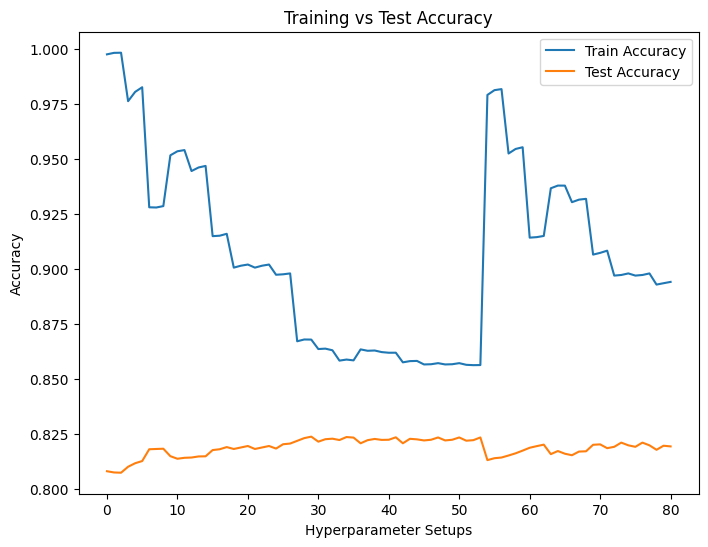

Test Accuracy: 0.8293885601577909
Test Precision: 0.8196315412931474
Test Recall: 0.8293885601577909
Test F1 Score: 0.8192310526900133
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2071
           1       0.68      0.41      0.51       499
           2       0.82      0.85      0.84       984
           3       0.75      0.70      0.73       502

    accuracy                           0.83      4056
   macro avg       0.78      0.73      0.75      4056
weighted avg       0.82      0.83      0.82      4056

Saved model to: ..\..\..\..\models\Map1\rf_model_v11.joblib
Best Cross-Validation Accuracy: 82.39%


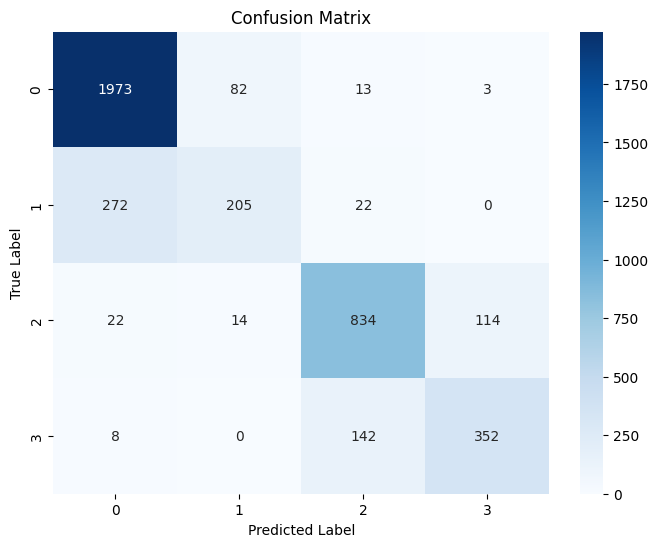

In [26]:
# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

# Calculate additional metrics
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
confusion = confusion_matrix(y_test, y_test_pred)

# Plot training and test accuracy
train_accuracy = grid_search.cv_results_['mean_train_score']
test_accuracy_cv = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy_cv, label='Test Accuracy')
plt.xlabel('Hyperparameter Setups')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.savefig(Path("../../../../IMG/RF_V11_accuracy_plot.png"))
plt.show()

# Log confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(Path("../../../../IMG/RF_V11_confusion_matrix.png"))  # Save confusion matrix

# Print results
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Classification Report:\n{test_report}")

# Save the best model to disk
rf_model_v11 = Path("../../../../models/Map1/rf_model_v11.joblib")
joblib.dump(best_model, rf_model_v11)
print(f"Saved model to: {rf_model_v11}")

# Evaluate using cross-validation accuracy
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")



>- Predict

In [19]:
# Load the best model
model = joblib.load(rf_model_v11)

def predict_growth_stage(image_path, model):
    features = extract_features(image_path)
    predicted_label = model.predict([features])[0]
    return growth_stages[predicted_label]

new_image = Path('../../../../data/model/Test/grand_growth/grand_growth_118FPLAN_76.tif')
predicted_stage = predict_growth_stage(new_image, model)
print(f"Predicted Growth Stage: {predicted_stage}")
print()

c:\Users\hashi\anaconda3\envs\research_env\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Predicted Growth Stage: grand_growth

